In [2]:
from requests import get, post
from web3 import Web3, HTTPProvider
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

In [78]:
BTC_merged = pd.read_csv("BTC_merged.csv", parse_dates=["date"])
BTC_merged.set_index('date', inplace=True)
BTC_merged = BTC_merged.tz_localize(None)
BTC_merged.info()

# Convert NaN values to 0
BTC_merged = BTC_merged.fillna(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1710 entries, 2019-09-10 to 2024-05-15
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BTC_Binance_funding_rate  1710 non-null   float64
 1   BTC_Bybit_funding_rate    1513 non-null   float64
 2   BTC_Deribit_funding_rate  1174 non-null   float64
 3   BTC_OKX_funding_rate      1001 non-null   float64
dtypes: float64(4)
memory usage: 66.8 KB


In [79]:
def process_funding_rates(df, column_name, position=1):
    """ Process funding rates and calculate interest and cumulative interest. """
    # Extract and rename the column
    new_df = df[[column_name]].rename(columns={column_name: 'funding_rate'})
    new_df['neg_funding_rate'] = new_df['funding_rate'].apply(lambda x: x if x < 0 else 0)

    # Calculate interest and cumulative interest
    new_df['interest'] = new_df['funding_rate'] * position / 365
    new_df['neg_interest'] = new_df['neg_funding_rate'] * position / 365
    
    new_df['cum_interest'] = new_df['interest'].cumsum()
    new_df['neg_cum_interest'] = new_df['neg_interest'].cumsum()
    
    return new_df

# List of columns and a dictionary to hold processed data
funding_rate_columns = [
    'BTC_Binance_funding_rate',
    'BTC_Bybit_funding_rate',
    'BTC_Deribit_funding_rate',
    'BTC_OKX_funding_rate'
]

# Process all funding rates in one loop and store them in a dictionary
processed_funding_rates = {
    col: process_funding_rates(BTC_merged, col) for col in funding_rate_columns
}

# Accessing the processed DataFrames
BTC_binance = processed_funding_rates['BTC_Binance_funding_rate']
BTC_bybit = processed_funding_rates['BTC_Bybit_funding_rate']
BTC_deribit = processed_funding_rates['BTC_Deribit_funding_rate']
BTC_okx = processed_funding_rates['BTC_OKX_funding_rate']

BTC_binance.info()
BTC_binance.head(5)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1710 entries, 2019-09-10 to 2024-05-15
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   funding_rate      1710 non-null   float64
 1   neg_funding_rate  1710 non-null   float64
 2   interest          1710 non-null   float64
 3   neg_interest      1710 non-null   float64
 4   cum_interest      1710 non-null   float64
 5   neg_cum_interest  1710 non-null   float64
dtypes: float64(6)
memory usage: 93.5 KB


,funding_rate,neg_funding_rate,interest,neg_interest,cum_interest,neg_cum_interest
date,,,,,,
2019-09-10,0.1095,0.0,0.0003,0.0,0.0003,0.0
2019-09-11,0.1095,0.0,0.0003,0.0,0.0006,0.0
2019-09-12,0.1095,0.0,0.0003,0.0,0.0009,0.0
2019-09-13,0.1095,0.0,0.0003,0.0,0.0012,0.0
2019-09-14,0.1095,0.0,0.0003,0.0,0.0015,0.0


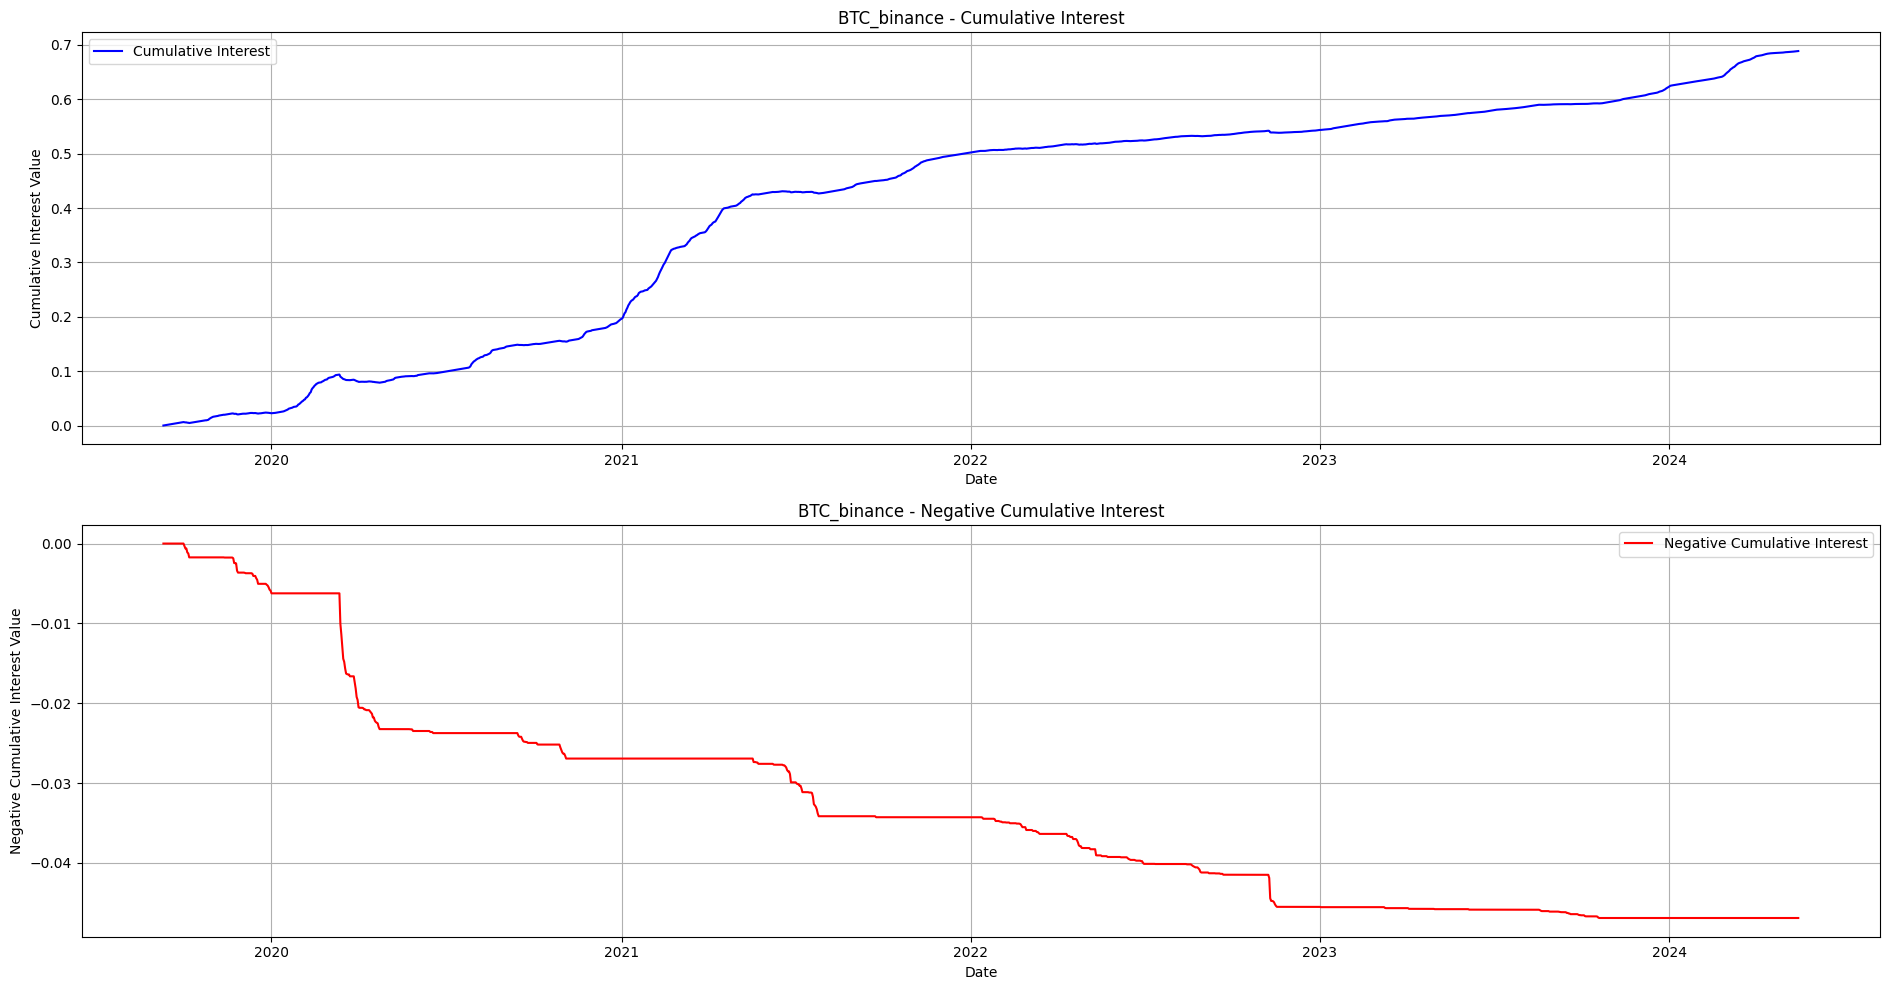

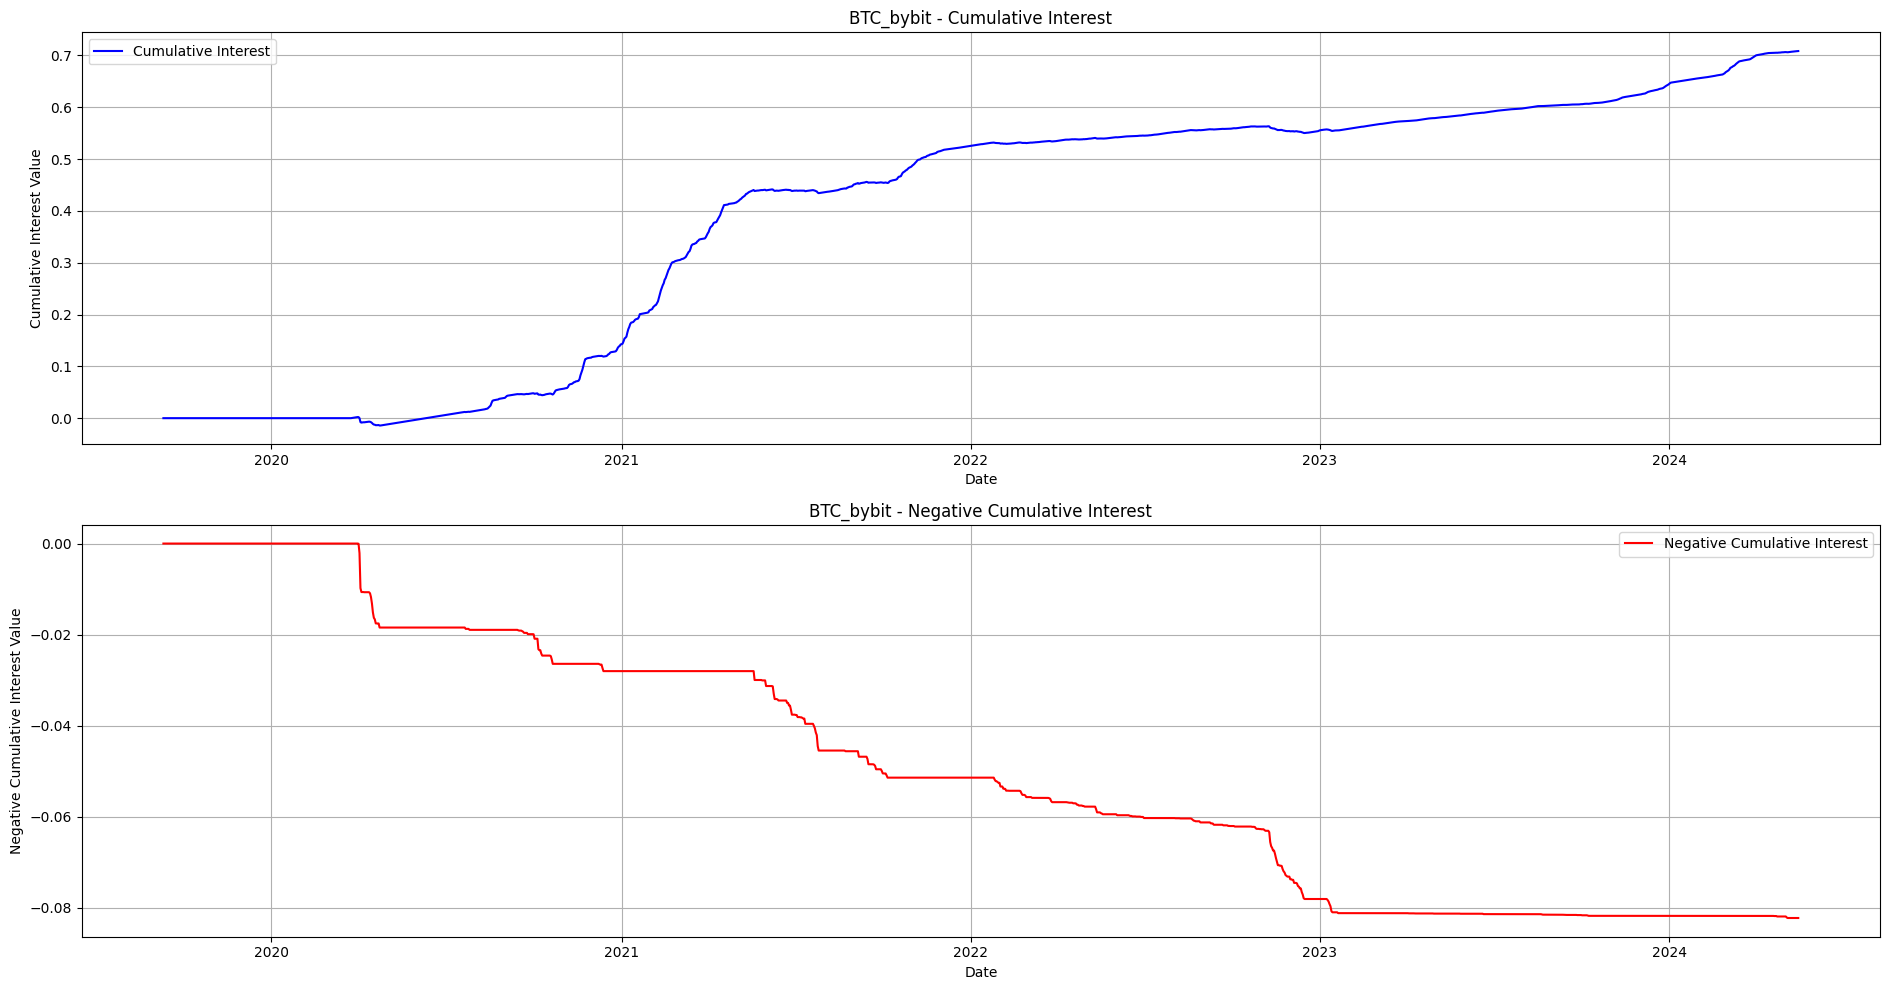

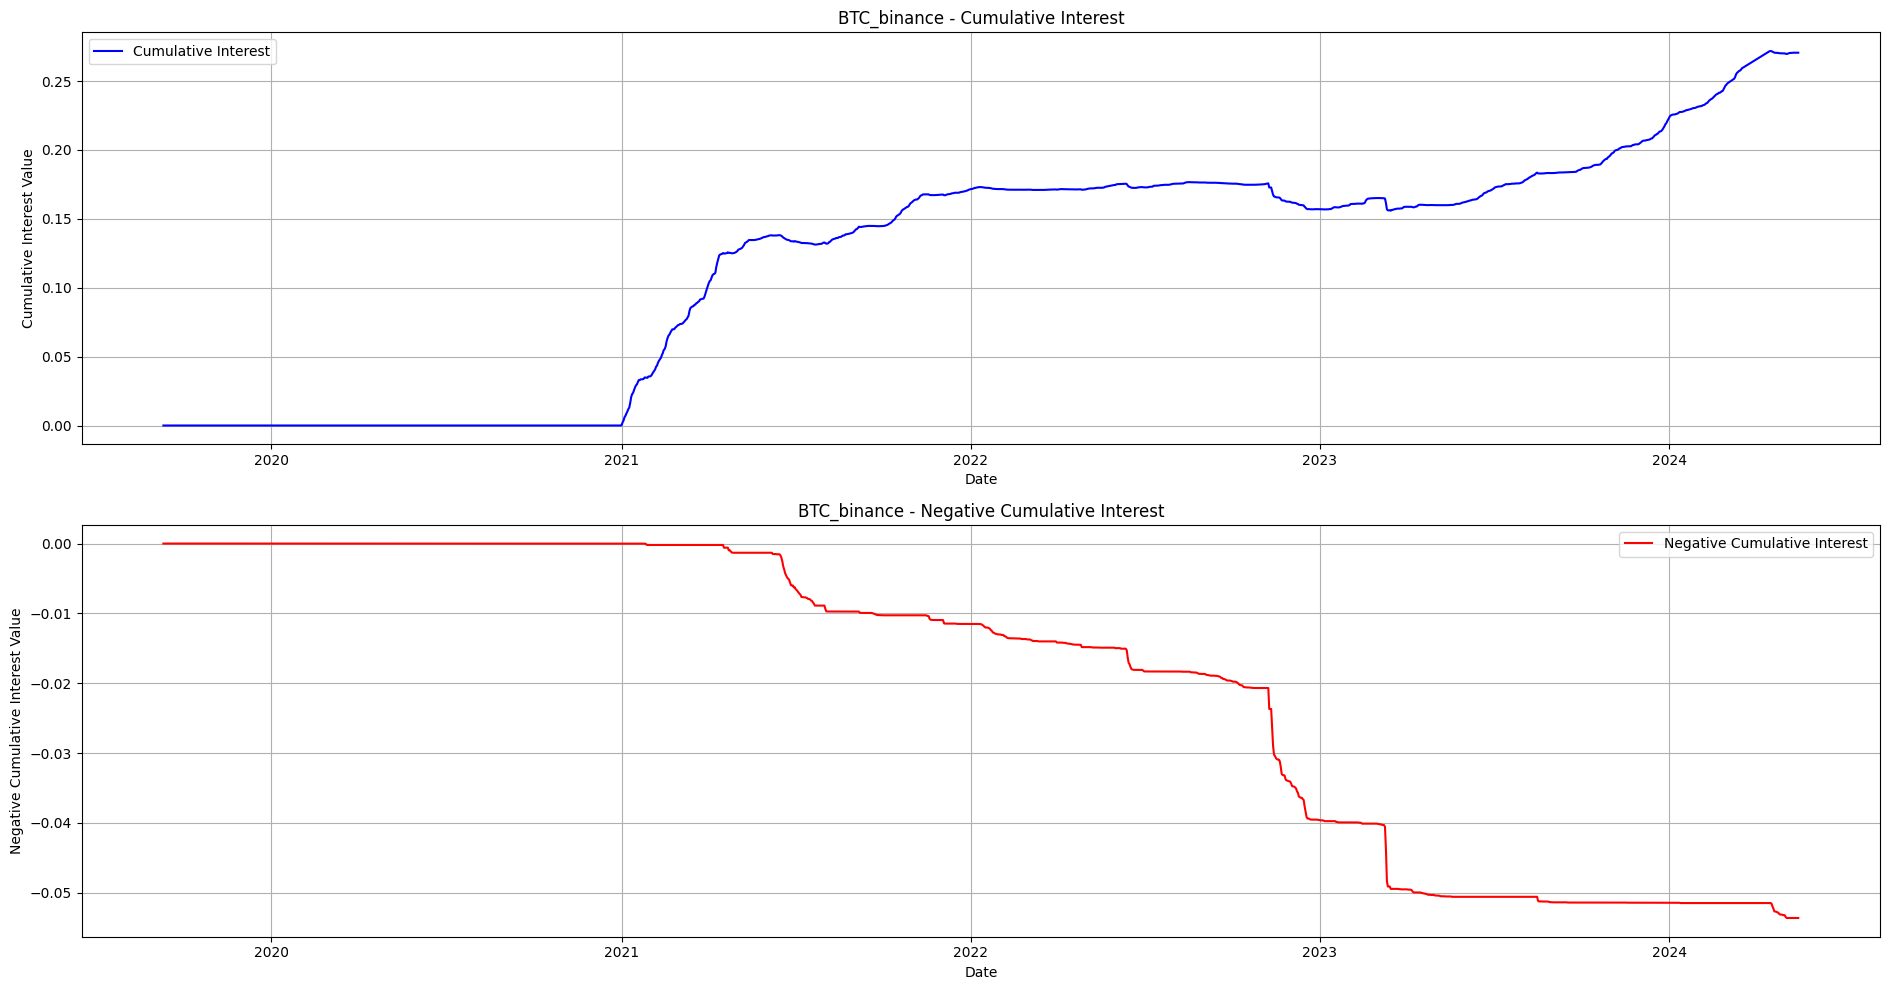

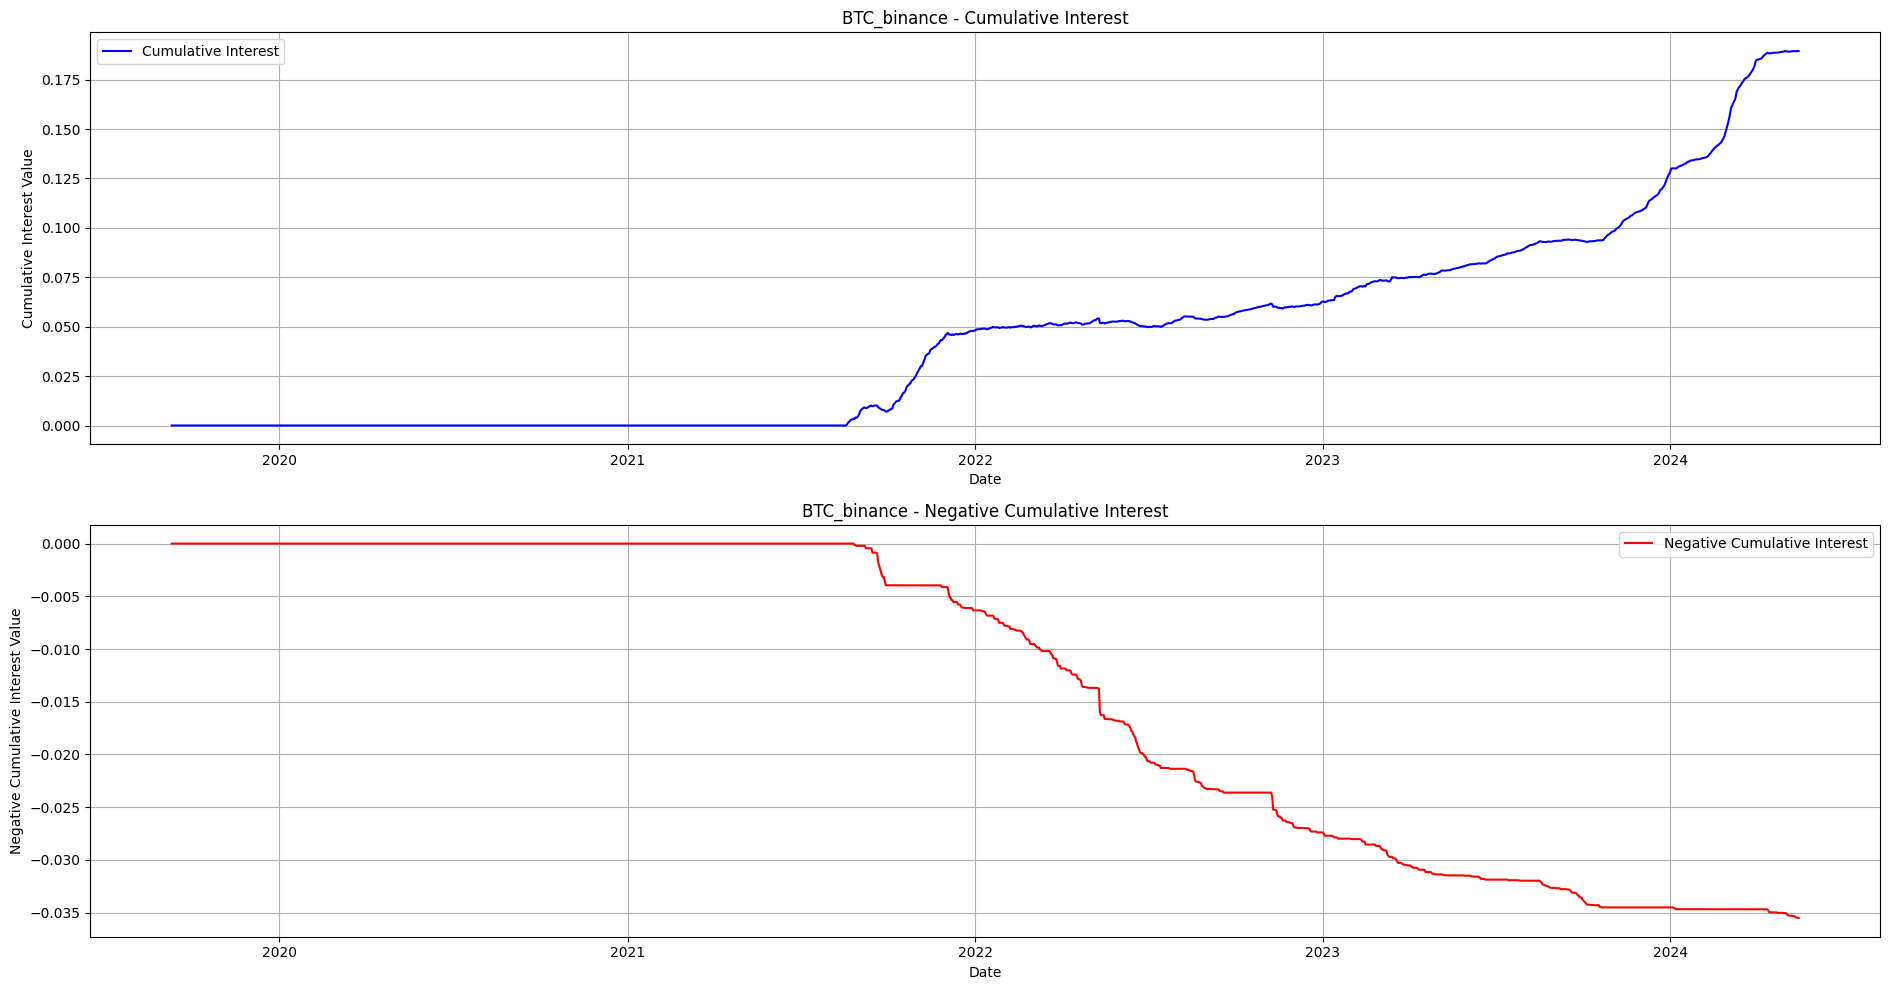

In [80]:
def plot_interest_with_highlights(df, title):
    """
    Plot cumulative interests with different highlighting methods for days with zero negative interest,
    displayed on separate subplots.

    Parameters:
    - df (DataFrame): DataFrame containing the interest data.
    - title (str): Title for the plot.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(19, 10))  # Two subplots in one column

    # Plot for cumulative interest
    ax1.plot(df.index, df['cum_interest'], label='Cumulative Interest', color='blue')
    ax1.set_title(f'{title} - Cumulative Interest')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Interest Value')
    ax1.legend()
    ax1.grid(True)

    # Plot for negative cumulative interest
    ax2.plot(df.index, df['neg_cum_interest'], label='Negative Cumulative Interest', color='red')
    ax2.set_title(f'{title} - Negative Cumulative Interest')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Negative Cumulative Interest Value')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


# Example usage:
plot_interest_with_highlights(BTC_binance, 'BTC_binance')
plot_interest_with_highlights(BTC_bybit, 'BTC_bybit')
plot_interest_with_highlights(BTC_deribit, 'BTC_binance')
plot_interest_with_highlights(BTC_okx, 'BTC_binance')

In [7]:
# Export to .csv file
# BTC_binance.to_csv('BTC_binance.csv', index=False)
# BTC_bybit.to_csv('BTC_bybit.csv', index=False)
# BTC_deribit.to_csv('BTC_deribit.csv', index=False)
# BTC_okx.to_csv('BTC_okx.csv', index=False)

---

## Methodology for drawdown detection

This guide explains the refined methodology used to detect and aggregate significant falls in the Insurance Fund, focusing on data smoothing and the proximity of detected falls to provide a simplified and intuitive analysis approach.

#### Key Components of the Approach

1. **Data Smoothing**: Reduces noise and highlights longer-term trends by averaging the data over a specified window.
2. **Fall Detection**: Identifies significant falls based on negative changes in the smoothed data.
3. **Fall Merging**: Aggregates closely occurring falls into single events based on a specified threshold.

#### Inputs Required from the User

Users need to provide two key parameters to customize the analysis:

1. **`window_size`**: Defines the breadth of the moving average window used for smoothing the data.
2. **`ignore_window`**: Specifies the maximum gap in days between consecutive falls that should be merged into a single fall.

### 1. Data Smoothing with Moving Average

**Purpose**: To mitigate the impact of minor, short-term fluctuations and emphasize more substantial trends or changes in the dataset.

**Parameter**: `window_size`
- **Type**: Integer
- **Description**: This parameter sets the number of days over which the moving average is calculated. A larger `window_size` results in smoother data, which can help in identifying more significant changes by diluting minor fluctuations.

**Example Usage**:
```python
# Applying a simple smoothing technique
binance_btc_df['smoothed_fund'] = binance_btc_df['Binance_insurance_fund'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
```

**Impact of Changes**:
- Increasing the `window_size` will generally produce a smoother trend line, which can be useful in focusing on more substantial changes in the dataset.
- Decreasing the `window_size` makes the data less smooth, potentially capturing more minor falls but also introducing more noise into the fall detection process.

### 2. Merging Close Falls

**Purpose**: To consolidate falls that occur close to each other into single significant events, simplifying analysis and interpretation.

**Parameter**: `ignore_window`
- **Type**: Integer
- **Description**: Determines how close in days two consecutive falls need to be to be considered as a single event. This helps in merging minor, closely spaced drops into a more significant fall, providing a clearer view of the fund's behavior.

**Example Usage**:
```python
# Merging falls that are close to each other based on ignore_window
if i - fall_start <= ignore_window:
    continue
```

**Impact of Changes**:
- A larger `ignore_window` means more falls will be merged, which is helpful when wanting to focus on broader trends and avoid overemphasizing minor falls.
- A smaller `ignore_window` retains more individual falls, useful for more granular analysis where every significant movement is critical.


In [8]:

def identify_and_merge_falls(df, window_size, ignore_window):
    """
    Identifies falls in the insurance fund and merges close falls into single events.

    Parameters:
    - df (DataFrame): DataFrame containing the insurance fund data.
    - window_size (int): Smoothing window size for rolling mean.
    - ignore_window (int): Number of days to consider merging falls that are close to each other.

    Returns:
    - DataFrame: Processed DataFrame with start and end dates and values of merged falls.
    """
    # Applying a simple smoothing technique using a rolling window
    df['smoothed_fund'] = df['neg_cum_interest'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')

    # Calculate the daily change in the smoothed insurance fund
    df['change_in_smoothed_fund'] = df['smoothed_fund'].diff().fillna(0)

    # Define a fall as a negative change
    df['is_fall'] = df['change_in_smoothed_fund'] < 0

    # Find the start and end of each significant fall period
    falls = []
    fall_start = None

    for i, row in df.iterrows():
        if row['is_fall']:
            if fall_start is None:
                fall_start = i
        else:
            if fall_start is not None:
                # Calculate the number of days between fall_start and i
                days_between = (i - fall_start).days
                if days_between <= ignore_window:
                    continue
                falls.append((fall_start, i - pd.Timedelta(days=1),
                              df.loc[fall_start, 'smoothed_fund'], df.loc[i - pd.Timedelta(days=1), 'smoothed_fund']))
                fall_start = None

    # Close any open fall period
    if fall_start is not None:
        falls.append((fall_start, df.index[-1],
                      df.loc[fall_start, 'smoothed_fund'], df.iloc[-1]['smoothed_fund']))

    # Create a DataFrame to summarize the falls
    falls_df = pd.DataFrame(falls, columns=['Start_Date', 'End_Date', 'Start_Fund', 'End_Fund'])
    falls_df['Difference'] = falls_df['Start_Fund'] - falls_df['End_Fund']

    return falls_df


# import matplotlib.dates as mdates

def plot_falls(df, falls_df, title):
    """
    Plots the insurance fund over time with highlighted falls, improved visualization.

    Parameters:
    - df (DataFrame): DataFrame containing the insurance fund data.
    - falls_df (DataFrame): DataFrame containing data about the falls.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(19, 10))
    
    # Plot original fund data
    plt.plot(df.index, df['neg_cum_interest'], label='Original Insurance Fund', color='#127475', linewidth=3, alpha=0.7)
    
    # Plot smoothed fund data
    plt.plot(df.index, df['smoothed_fund'], label='Smoothed Fund', color='skyblue', linewidth=3)
    
    # Highlight fall periods
    for i, row in falls_df.iterrows():
        fall_period = df.loc[row['Start_Date']:row['End_Date']]
        plt.plot(fall_period.index, fall_period['smoothed_fund'], color='red', linewidth=1, alpha=0.8)
        
        # Add text annotation for each fall
        mid_point = fall_period.index[len(fall_period) // 2]
        plt.annotate(f'Fall {i+1}', (mid_point, fall_period['smoothed_fund'].iloc[len(fall_period) // 2]),
                     xytext=(0, 30), textcoords='offset points', ha='center', va='bottom',
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Add a legend entry for falls
    plt.plot([], [], color='red', linewidth=2, label='Fall Periods')
    
    plt.title(f'{title} - Insurance Fund Over Time with Smoothed Data and Highlighted Falls')
    plt.xlabel('Date')
    plt.ylabel('Insurance Fund (BTC)')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # plt.tight_layout()
    plt.show()
    

C:\Users\dhruv\AppData\Local\Temp\ipykernel_448\2463846046.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['smoothed_fund'] = df['neg_cum_interest'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')


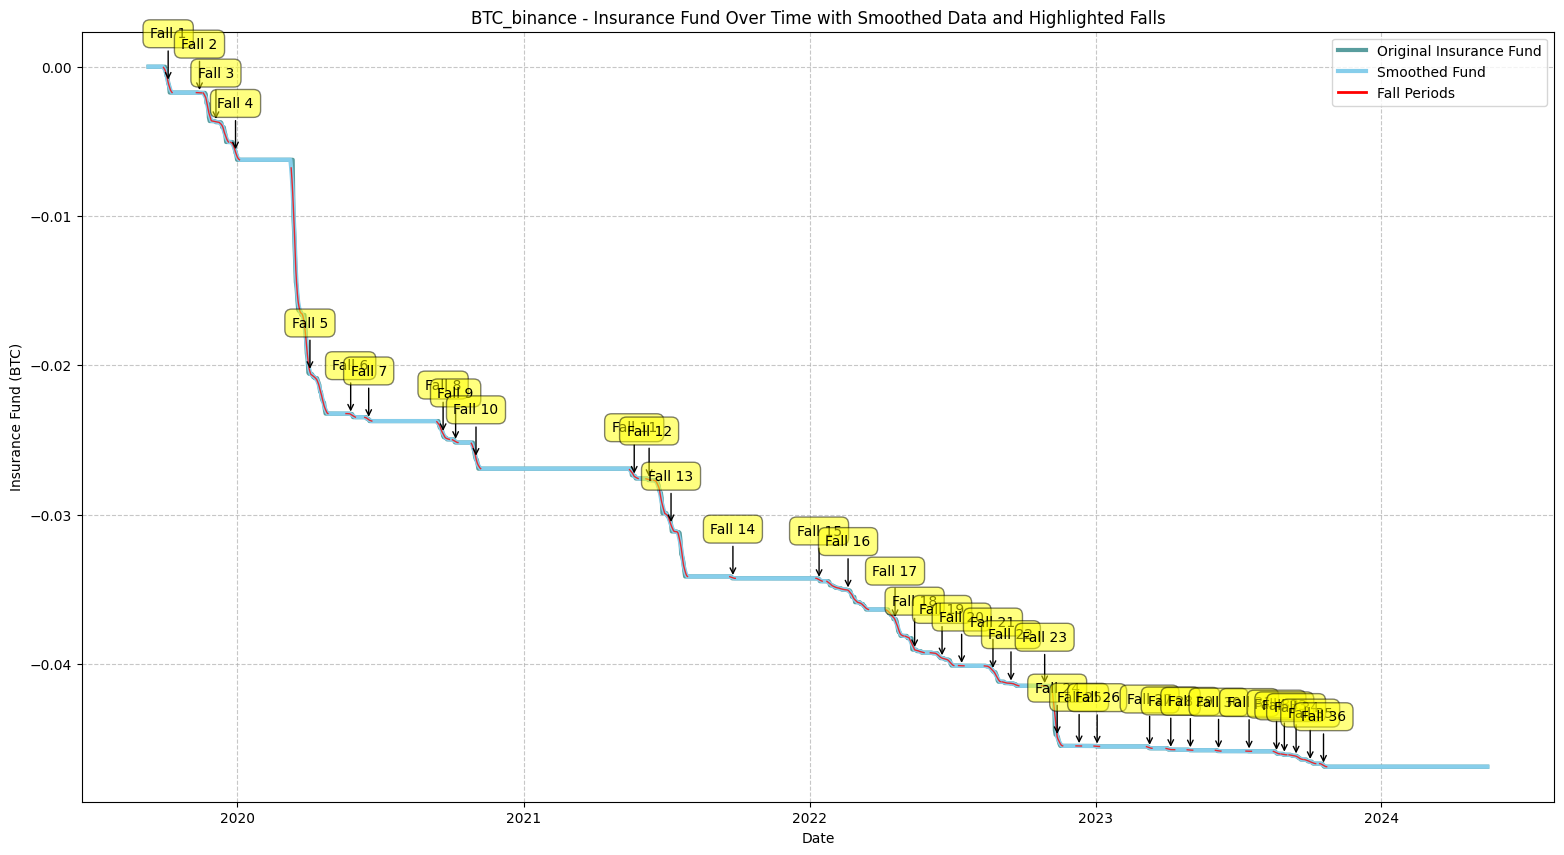

C:\Users\dhruv\AppData\Local\Temp\ipykernel_448\2463846046.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['smoothed_fund'] = df['neg_cum_interest'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')


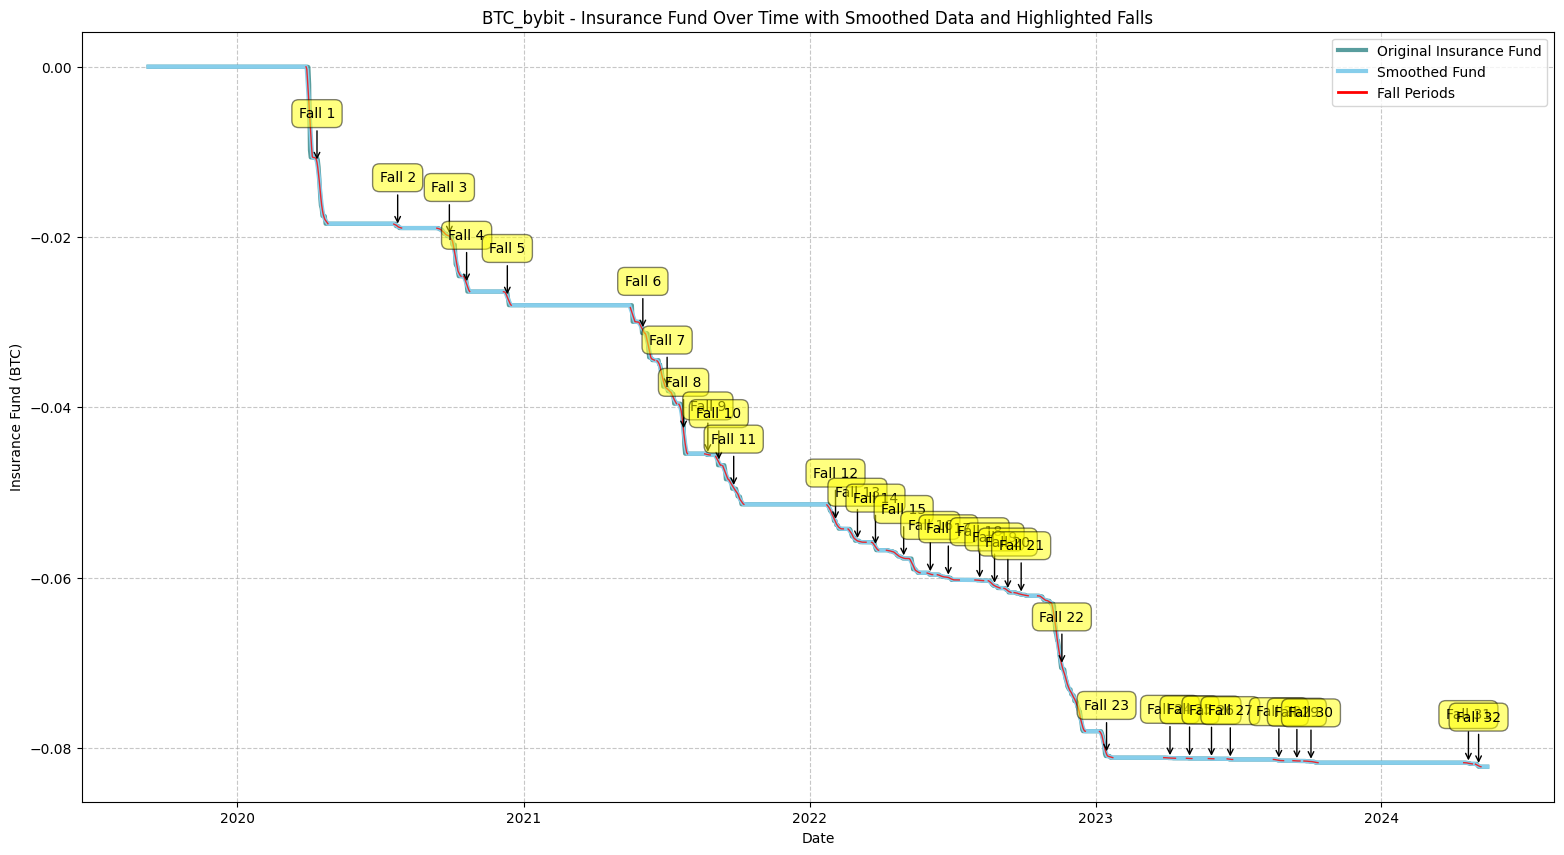

C:\Users\dhruv\AppData\Local\Temp\ipykernel_448\2463846046.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['smoothed_fund'] = df['neg_cum_interest'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')


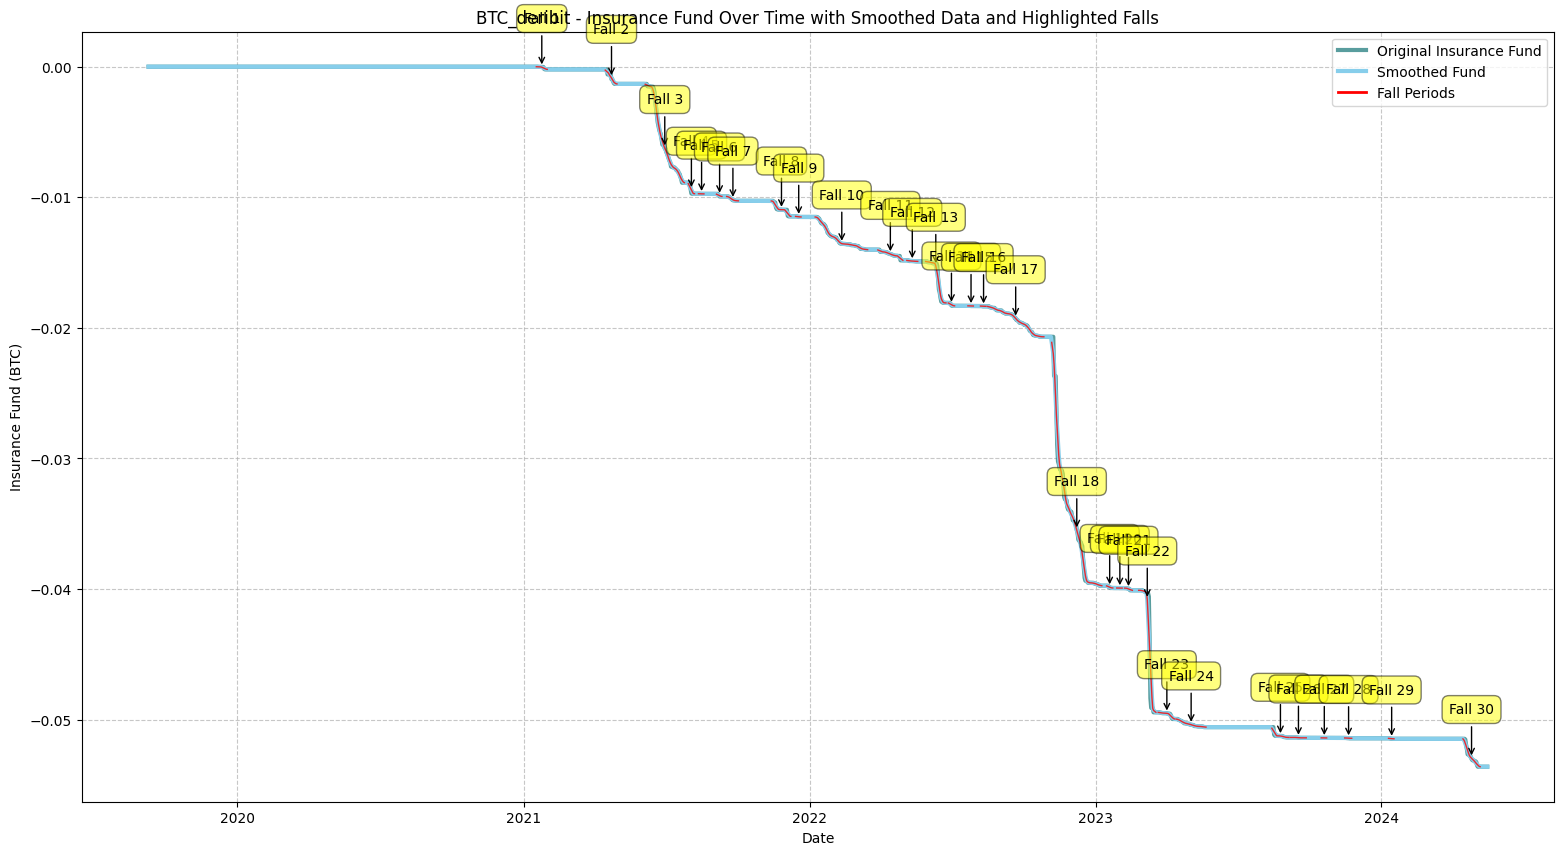

C:\Users\dhruv\AppData\Local\Temp\ipykernel_448\2463846046.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['smoothed_fund'] = df['neg_cum_interest'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')


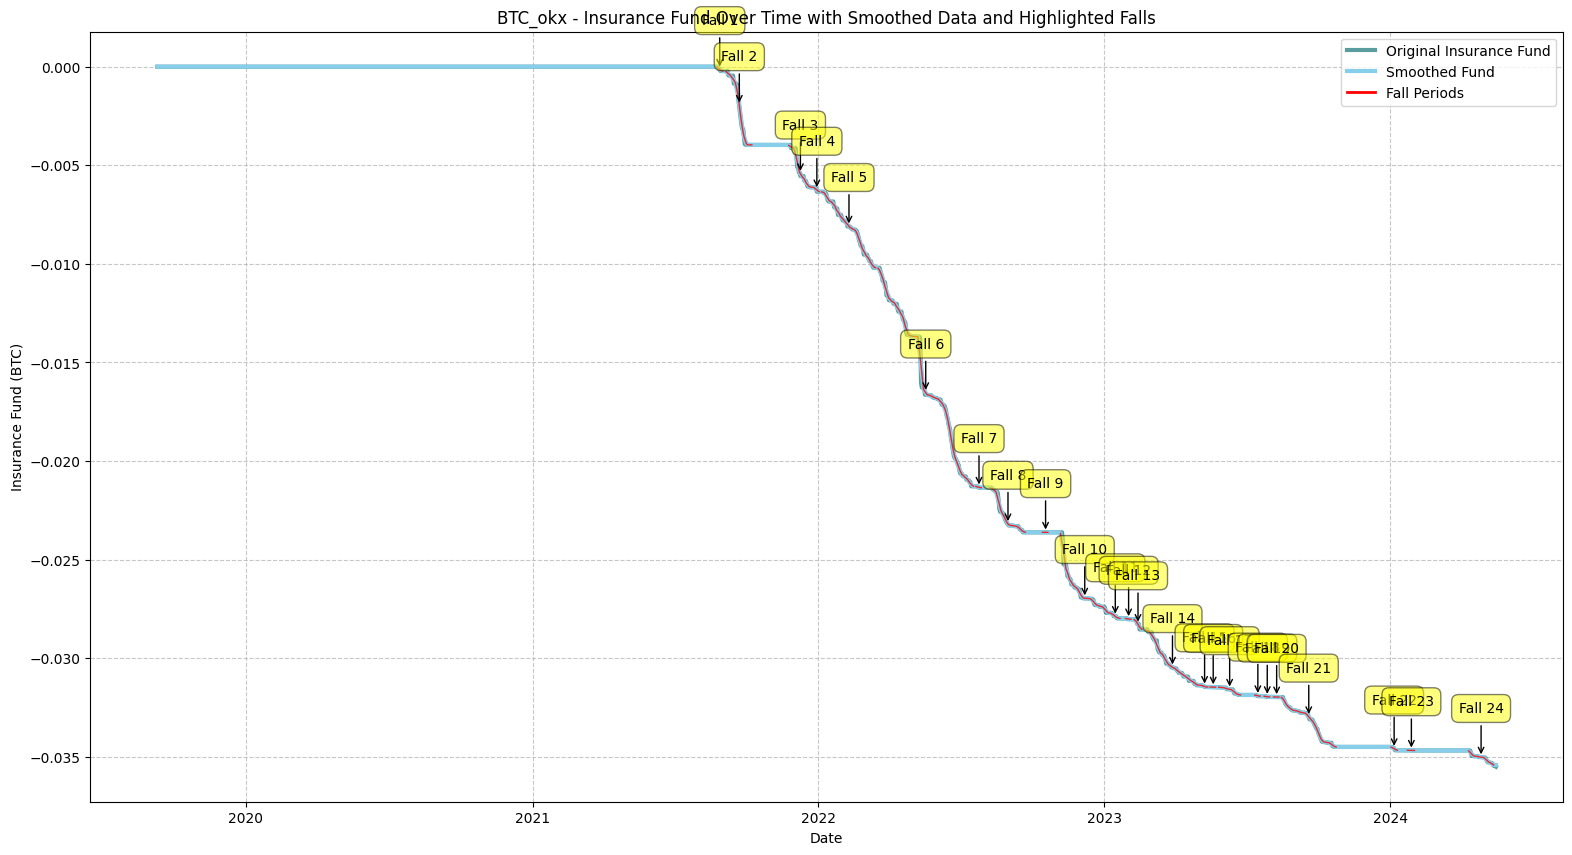

In [54]:
BTC_binance_falls = identify_and_merge_falls(BTC_binance, window_size=7, ignore_window=7)
plot_falls(BTC_binance, BTC_binance_falls, 'BTC_binance')

BTC_bybit_falls = identify_and_merge_falls(BTC_bybit, window_size=7, ignore_window=7)
plot_falls(BTC_bybit, BTC_bybit_falls, 'BTC_bybit')

BTC_deribit_falls = identify_and_merge_falls(BTC_deribit, window_size=7, ignore_window=7)
plot_falls(BTC_deribit, BTC_deribit_falls, 'BTC_deribit')

BTC_okx_falls = identify_and_merge_falls(BTC_okx, window_size=7, ignore_window=7)
plot_falls(BTC_okx, BTC_okx_falls, 'BTC_okx')

# Export to .csv file
BTC_binance_falls.to_csv('../isolated/drawdown_data/BTC_binance_falls.csv', index=False)
BTC_bybit_falls.to_csv('../isolated/drawdown_data/BTC_bybit_falls.csv', index=False)
BTC_deribit_falls.to_csv('../isolated/drawdown_data/BTC_deribit_falls.csv', index=False)
BTC_okx_falls.to_csv('../isolated/drawdown_data/BTC_okx_falls.csv', index=False)

In [55]:
def extract_max_difference_row(df):
    """
    Extracts the row with the maximum 'Difference' from the DataFrame.

    Parameters:
    - df (DataFrame): DataFrame containing the columns 'Start_Date', 'End_Date', 'Start_Fund', 'End_Fund', 'Difference'.

    Returns:
    - list: A list containing a dictionary where each key-value pair corresponds to column-name and cell-value of the row with the maximum 'Difference'.
    """
    max_diff_row = df.loc[df['Difference'].idxmax()]
    return [max_diff_row.to_dict()]


BTC_binance_falls_max = extract_max_difference_row(BTC_binance_falls)[0]
BTC_bybit_falls_max = extract_max_difference_row(BTC_bybit_falls)[0]
BTC_deribit_falls_max = extract_max_difference_row(BTC_deribit_falls)[0]
BTC_okx_falls_max = extract_max_difference_row(BTC_okx_falls)[0]

In [64]:
OUTPUT_COMP = [
{
'col_name': 'BTC_Binance_funding_rate',
'exchange': 'Binance',
'rate': BTC_binance,
'drawdown': BTC_binance_falls,
'max_drawdown': BTC_binance_falls_max,
'max_drawdown_rates': None,
'insurance_fund': None,
},

{
'col_name': 'BTC_Bybit_funding_rate',
'exchange': 'Bybit',
'rate': BTC_bybit,
'drawdown': BTC_bybit_falls,
'max_drawdown': BTC_bybit_falls_max,
'max_drawdown_rates': None,
'insurance_fund': None,
},
{
'col_name': 'BTC_Deribit_funding_rate',
'exchange': 'Deribit',
'rate': BTC_deribit,
'drawdown': BTC_deribit_falls,
'max_drawdown': BTC_deribit_falls_max,
'max_drawdown_rates': None,
'insurance_fund': None,
},
{
'col_name': 'BTC_OKX_funding_rate',
'exchange': 'Okx',
'rate': BTC_okx,
'drawdown': BTC_okx_falls,
'max_drawdown': BTC_okx_falls_max,
'max_drawdown_rates': None,
'insurance_fund': None,
},
]

def extract_rate_from_endpoints(rate_df, endpoint_dict, cex=None):
    """
    Extracts funding rate data for a specified date range and formats it into a new DataFrame.

    Parameters:
    - rate_df (DataFrame): DataFrame containing the columns 'funding_rate' and 'neg_funding_rate'.
    - endpoint_dict (dict): Dictionary with keys 'Start_Date', 'End_Date' containing the date range and other metadata.
    - cex (str, optional): Central Exchange name to customize the output column names.

    Returns:
    - DataFrame: A DataFrame with two columns for funding rates over the specified date range.
    """
    # Extract date range from endpoint_dict
    start_date = endpoint_dict['Start_Date']
    end_date = endpoint_dict['End_Date']
    
    # Slice the DataFrame to get data within the specified date range
    sliced_df = rate_df.loc[start_date:end_date]
    
    # Define column names based on whether a CEX name is provided
    if cex:
        funding_rate_col = f"{cex}_funding_rate"
        neg_funding_rate_col = f"{cex}_neg_funding_rate"
        cum_interest_col = f"{cex}_cum_interest"
        neg_cum_interest_col = f"{cex}_neg_cum_interest"
        	
    else:
        funding_rate_col = "funding_rate"
        neg_funding_rate_col = "neg_funding_rate"
        cum_interest_col = "cum_interest"
        neg_cum_interest_col = "neg_cum_interest"

    # Create a new DataFrame with the specified column names
    new_df = pd.DataFrame({
        funding_rate_col: sliced_df['funding_rate'],
        neg_funding_rate_col: sliced_df['neg_funding_rate'],
        cum_interest_col: sliced_df['cum_interest'],
        neg_cum_interest_col: sliced_df['neg_cum_interest'],
    })

    return new_df

for comp in OUTPUT_COMP:
    comp['max_drawdown_rates'] = extract_rate_from_endpoints(comp['rate'], comp['max_drawdown'], cex=comp['exchange'])
        
OUTPUT_COMP

[{'col_name': 'BTC_Binance_funding_rate',
  'exchange': 'Binance',
  'rate':             funding_rate  neg_funding_rate  interest  neg_interest  \
  date                                                                 
  2019-09-10      0.109500               0.0  0.000300           0.0   
  2019-09-11      0.109500               0.0  0.000300           0.0   
  2019-09-12      0.109500               0.0  0.000300           0.0   
  2019-09-13      0.109500               0.0  0.000300           0.0   
  2019-09-14      0.109500               0.0  0.000300           0.0   
  ...                  ...               ...       ...           ...   
  2024-05-11      0.064674               0.0  0.000177           0.0   
  2024-05-12      0.056334               0.0  0.000154           0.0   
  2024-05-13      0.100813               0.0  0.000276           0.0   
  2024-05-14      0.088542               0.0  0.000243           0.0   
  2024-05-15      0.052642               0.0  0.000144       

In [65]:
result = []

for comp in OUTPUT_COMP:
    new_dict = {}
    new_dict['exchange'] = comp['exchange']
    new_dict['max_drawdown_percent'] = comp['max_drawdown']['Difference'] * -100
    # Calculate overall percent change from max_drawdown_rates DataFrame
    df = comp['max_drawdown_rates']
    if not df.empty and f'{comp['exchange']}_cum_interest' in df.columns:
        first_value = df[f'{comp['exchange']}_cum_interest'].iloc[0]  # First value in the column
        last_value = df[f'{comp['exchange']}_cum_interest'].iloc[-1]  # Last value in the column
        new_dict['overall_percent'] = (last_value - first_value) * 100
    else:
        new_dict['overall_percent'] = None  # or a default value or error message

    new_dict['drawdown_start'] = comp['max_drawdown']['Start_Date']
    new_dict['drawdown_end'] = comp['max_drawdown']['End_Date']
    new_dict['buffer'] = new_dict['overall_percent'] - new_dict['max_drawdown_percent']
    new_dict['asset'] = 'BTC'
    
    # Add the new dictionary to the list
    result.append(new_dict)

resulting_df = pd.DataFrame(result)
resulting_df.head(5)


,exchange,max_drawdown_percent,overall_percent,drawdown_start,drawdown_end,buffer,asset
0,Binance,-1.645862,-1.357579,2020-03-10,2020-04-26,0.288283,BTC
1,Bybit,-1.843056,-1.505371,2020-03-29,2020-04-26,0.337685,BTC
2,Deribit,-1.863220,-1.855361,2022-11-06,2023-01-09,0.007860,BTC
3,Okx,-1.106325,-0.077900,2022-03-18,2022-07-18,1.028425,BTC


In [66]:
# Export to .csv file
resulting_df.to_csv('BTC_impact.csv', index=False)

---

## ⚠️ WIP

In [10]:
TEST_BTC_binance = processed_funding_rates['BTC_Binance_funding_rate']
TEST_BTC_binance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1710 entries, 2019-09-10 to 2024-05-15
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   funding_rate             1710 non-null   float64
 1   neg_funding_rate         1710 non-null   float64
 2   interest                 1710 non-null   float64
 3   neg_interest             1710 non-null   float64
 4   cum_interest             1710 non-null   float64
 5   neg_cum_interest         1710 non-null   float64
 6   smoothed_fund            1710 non-null   float64
 7   change_in_smoothed_fund  1710 non-null   float64
 8   is_fall                  1710 non-null   bool   
dtypes: bool(1), float64(8)
memory usage: 186.4 KB


Missing values:
0

Summary statistics:
count    1710.000000
mean        0.146964
std         0.246482
min        -1.392296
25%         0.044229
50%         0.109500
75%         0.109500
max         1.868577
Name: funding_rate, dtype: float64


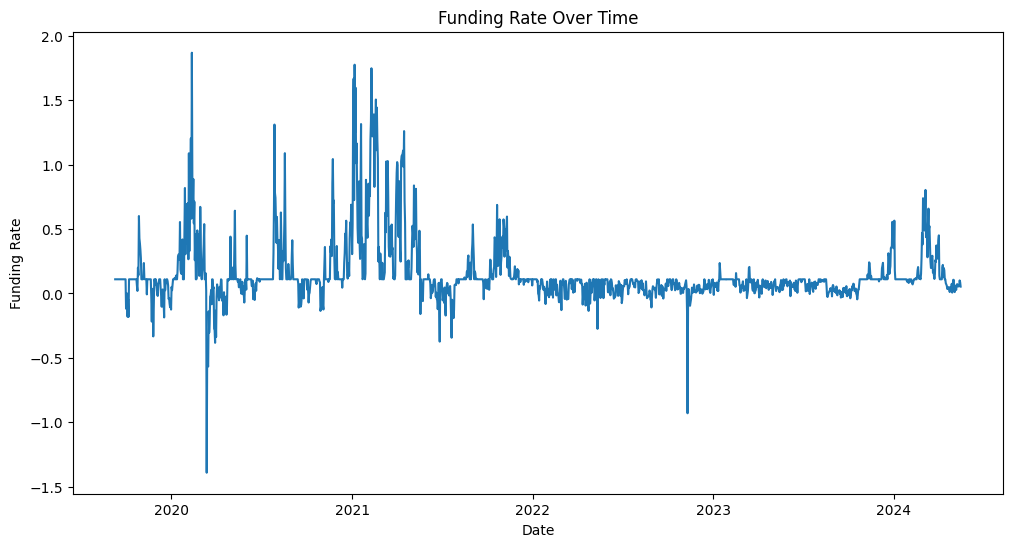


Augmented Dickey-Fuller Test:
ADF Statistic: -4.784574935778379
p-value: 5.820411688605721e-05
Critical Values:
	1%: -3.4342253019858457
	5%: -2.863251727422817
	10%: -2.567681279366969


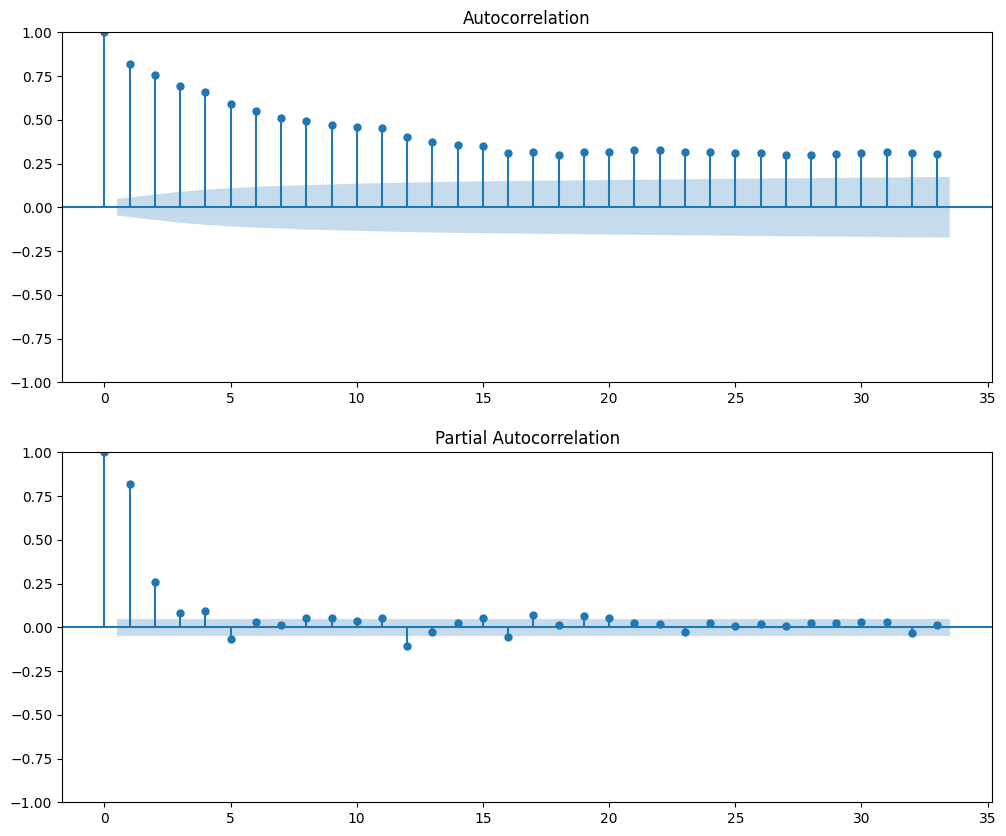

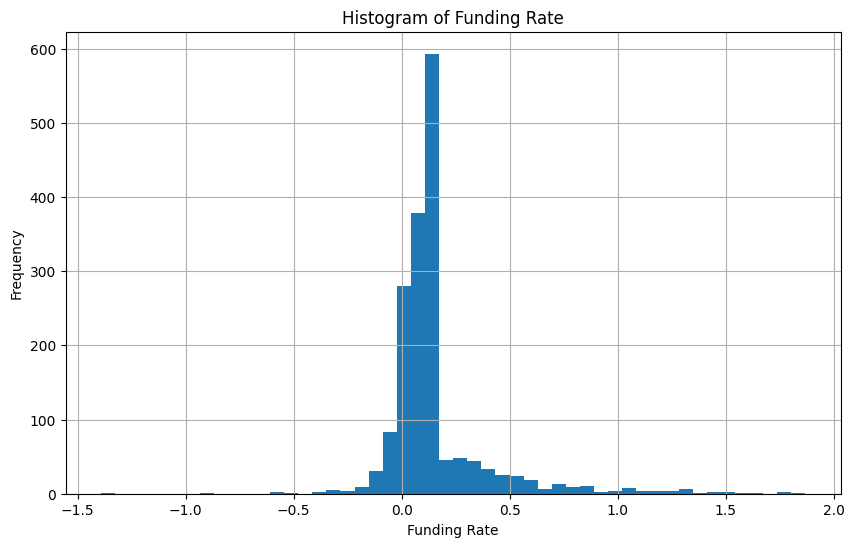

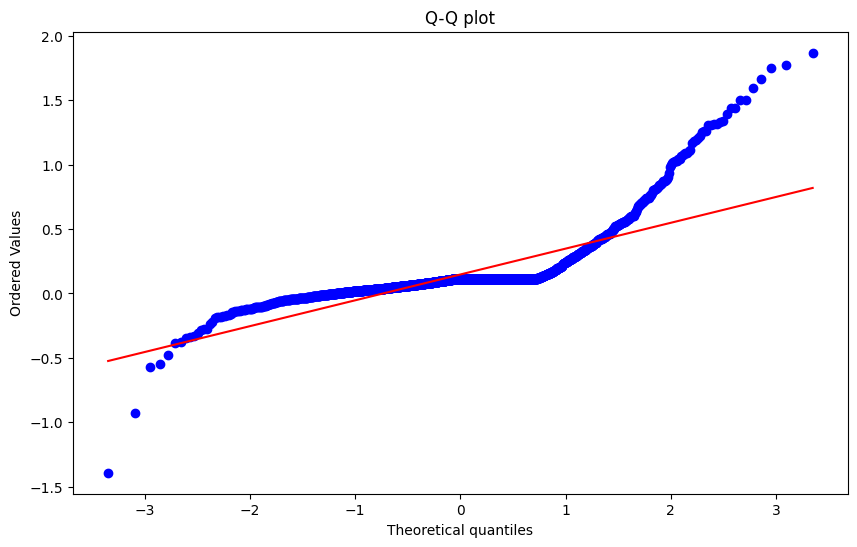

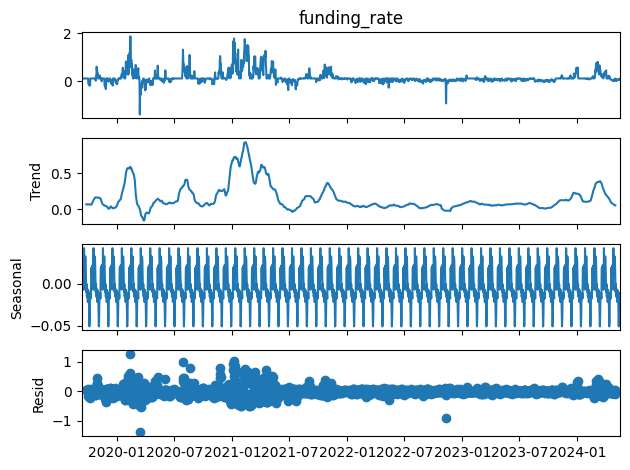

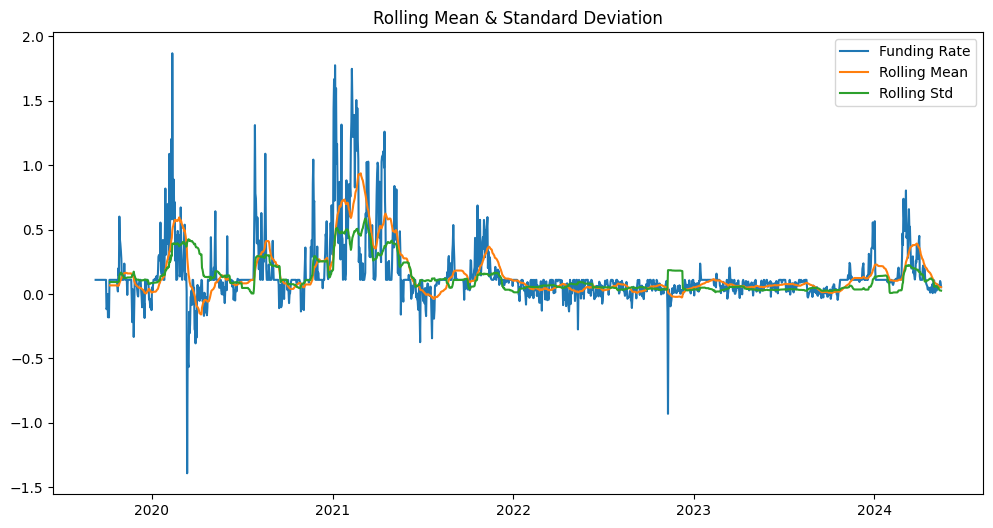

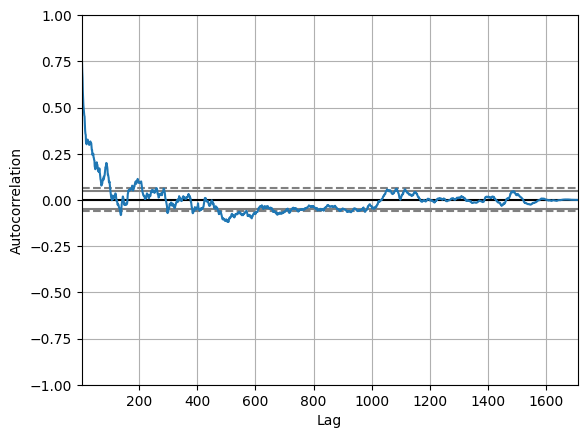

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming TEST_BTC_binance is already a DataFrame with DatetimeIndex
df = TEST_BTC_binance

# Step 1: Data Exploration and Preprocessing

# a. Check for missing values and outliers
print("Missing values:")
print(df['funding_rate'].isnull().sum())

print("\nSummary statistics:")
print(df['funding_rate'].describe())

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['funding_rate'])
plt.title('Funding Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Funding Rate')
plt.show()

# b. Test for stationarity (Augmented Dickey-Fuller test)
result = adfuller(df['funding_rate'].dropna())
print('\nAugmented Dickey-Fuller Test:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# c. Check for autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df['funding_rate'].dropna(), ax=ax1)
plot_pacf(df['funding_rate'].dropna(), ax=ax2)
plt.show()

# Step 2: Distribution Analysis

# a. Plot histogram
plt.figure(figsize=(10, 6))
df['funding_rate'].hist(bins=50)
plt.title('Histogram of Funding Rate')
plt.xlabel('Funding Rate')
plt.ylabel('Frequency')
plt.show()

# b. Q-Q plot
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(df['funding_rate'].dropna(), dist="norm", plot=ax)
ax.set_title("Q-Q plot")
plt.show()

# # c. Normality tests
# _, p_value_shapiro = stats.shapiro(df['funding_rate'].dropna())
# _, p_value_anderson = stats.anderson(df['funding_rate'].dropna())

# print("\nNormality Tests:")
# print(f"Shapiro-Wilk Test p-value: {p_value_shapiro}")
# print(f"Anderson-Darling Test statistic: {p_value_anderson.statistic}")
# print("Anderson-Darling Test critical values:", p_value_anderson.critical_values)

# Step 3: Time Series Analysis

# a. Check for seasonality
decomposition = seasonal_decompose(df['funding_rate'], model='additive', period=30)  # Assuming monthly seasonality
fig = decomposition.plot()
plt.show()

# Calculate rolling statistics
rolling_mean = df['funding_rate'].rolling(window=30).mean()
rolling_std = df['funding_rate'].rolling(window=30).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['funding_rate'], label='Funding Rate')
plt.plot(df.index, rolling_mean, label='Rolling Mean')
plt.plot(df.index, rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Autocorrelation plot
pd.plotting.autocorrelation_plot(df['funding_rate'])
plt.show()

Thank you for providing these results and images. Let's interpret the data we have:

1. Data Exploration:
   - There are no missing values in the funding_rate column.
   - The mean funding rate is 0.146964, with a standard deviation of 0.246482.
   - The minimum rate is -1.392296, and the maximum is 1.868577.
   - The median (50th percentile) is 0.109500, which is lower than the mean, suggesting a right-skewed distribution.

2. Stationarity Test:
   - The Augmented Dickey-Fuller test result shows:
     ADF Statistic: -4.784574935778379
     p-value: 5.820411688605721e-05
   - Since the p-value is very small (< 0.05), we reject the null hypothesis of non-stationarity. This suggests the time series is stationary.

3. Distribution Analysis:
   - Q-Q plot (Image 1): The plot shows deviations from the straight line, especially at the tails. This indicates that the data is not perfectly normally distributed. There's a slight S-shape, suggesting heavier tails than a normal distribution.

4. Autocorrelation Analysis (Image 2):
   - The ACF plot shows significant autocorrelation that decays slowly over time, indicating strong serial dependence.
   - The PACF plot shows a large spike at lag 1 and smaller, significant spikes at a few other lags, suggesting an autoregressive component in the data.

5. Normality Tests:
   - The Shapiro-Wilk test was performed, but we don't have the p-value in the output.
   - There was an error when trying to perform the Anderson-Darling test.

Based on these results, we can conclude:

1. The data is stationary, which is good for many time series models.
2. The distribution is not perfectly normal, showing heavier tails and possible skewness.
3. There is significant autocorrelation in the data, which needs to be accounted for in our modeling approach.

Given these characteristics, here are the next steps I recommend:

1. Use an ARIMA (AutoRegressive Integrated Moving Average) or SARIMA (Seasonal ARIMA) model to account for the autocorrelation structure in the data.
2. Consider using a GARCH (Generalized AutoRegressive Conditional Heteroskedasticity) model in combination with ARIMA to account for potential volatility clustering, which is common in financial data.
3. For probability calculations, we might need to use empirical methods or bootstrap resampling rather than relying on normal distribution assumptions.

To proceed, we should:

1. Fit an ARIMA model to the data.
2. Use the fitted model to generate simulations.
3. Calculate probabilities based on these simulations.

Would you like me to provide code for fitting an ARIMA model and using it for probability calculations?

In [12]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.stattools import adfuller
# from itertools import product
# from tqdm import tqdm

# # Assuming TEST_BTC_binance is your DataFrame with 'funding_rate' column and DatetimeIndex

# def find_best_arima_order(data, max_p=5, max_d=2, max_q=5):
#     best_aic = np.inf
#     best_order = None
#     for p, d, q in product(range(max_p + 1), range(max_d + 1), range(max_q + 1)):
#         try:
#             model = ARIMA(data, order=(p, d, q))
#             results = model.fit()
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = (p, d, q)
#         except:
#             continue
#     return best_order

# def fit_arima_model(data, order):
#     model = ARIMA(data, order=order)
#     results = model.fit()
#     return results

# def simulate_future_values(model, steps, n_simulations):
#     simulations = []
#     for _ in range(n_simulations):
#         sim = model.simulate(nsimulations=steps)
#         simulations.append(sim)
#     return np.array(simulations)

# def calculate_probability(simulations, threshold, days):
#     averages = np.mean(simulations[:, :days], axis=1)
#     prob = np.mean(averages >= threshold)
#     return prob

# # Main process
# data = TEST_BTC_binance['funding_rate']

# # Find best ARIMA order
# print("Finding best ARIMA order...")
# best_order = find_best_arima_order(data)
# print(f"Best ARIMA order: {best_order}")

# # Fit the ARIMA model
# print("Fitting ARIMA model...")
# model = fit_arima_model(data, best_order)

# # Set parameters for probability calculation
# n_simulations = 10000
# n_days = 7  # Number of consecutive days
# threshold = -0.4  # Example threshold for average funding rate

# # Simulate future values
# print(f"Simulating {n_simulations} future scenarios...")
# simulations = simulate_future_values(model, n_days, n_simulations)

# # Calculate probability
# prob = calculate_probability(simulations, threshold, n_days)
# print(f"Probability of average funding rate >= {threshold} for {n_days} consecutive days: {prob:.2%}")

# # Visualize results
# plt.figure(figsize=(12, 6))
# plt.hist(np.mean(simulations, axis=1), bins=50, edgecolor='black')
# plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
# plt.title(f'Distribution of Average Funding Rates over {n_days} Days')
# plt.xlabel('Average Funding Rate')
# plt.ylabel('Frequency')
# plt.show()